# TP1 - Problema 2

Grupo 23
<br>
Pedro Gonçalves a101250
<br>
José Loureiro a96467
<br>
Bruno Neiva a95311

Problema 2: 
<br>
Um sistema de tráfego é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e os arcos denotam vias de comunicação só com um sentido. O grafo tem de ser ligado, ou seja, entre cada par de nodos ⟨n
​1
​​ ,n
​2
​​ ⟩ existe um caminho n1 -> n2 e um caminho n2 -> n1.

1. Gerar aleatoriamente o grafo com um número de nodos entre 6 e 10 e com ramos verificando:
<br>
i. Cada nodo tem um número aleatório de descendentes entre 1 a 3 cujos destinos são também gerados aleatoriamente.
<br>
ii. Se  existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.

2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado. 

In [7]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random

MAX_DESCENDENTES = 3

Iremos agora proceder à geração de um digrafo G aleatóriamente. Com este metodo criamos os nodos n1,n2,...,nk com k pertencente a {6,..,10} e de seguida ligamos estes nodos num loop, ou seja, criamos as arestas (n1,n2), (n2,n3),...,(nk,n1)


Para terminar iteramos por todos os nodos e adicionamos um núumero de arestas aleatorias n, onde 0 <= n <= MAX_DESCENDENTES - 1, isto pois nesta altura todos os nossos nodos têm um descendente, logo n tem que variar entre 0 e 2 para que cada nodo tenha entre 1 a 3 descendentes.

In [8]:
def gerador():
    G = nx.DiGraph()
    r = random.randint(6, 10) #randomizar numero de nodos entre 6 e 10
    nodos = [n for n in range(1, r + 1)]
    
    G.add_nodes_from(nodos)
    random.shuffle(nodos)
    
    for x in range(len(nodos) - 1):
        G.add_edge(nodos[x], nodos[x+1])
    G.add_edge(nodos[len(nodos) - 1], nodos[0])
    
    for v in nodos:
        l = [n for n in nodos if n != v] #escolhemos todos os nodos como candidatos a descendentes, exeto o nodo atual
        f = []
        for nodo in l:
             if not G.has_edge(nodo, v):
                 f.append(nodo)
        random.shuffle(f)
        num_descendentes = random.randint(0, MAX_DESCENDENTES - 1) #MAX_DESCENDENTES -1 pois todos os vertíces já têm 1 aresta
        for i in range(num_descendentes):
            G.add_edge(v, f[i])
    return G    

Iremos agora fazer a função que gera um subgrafo orientado ligado de G com o número mínimo de arestas possíveis.

Começamos por criar um solver e um dicionário `A` onde as chaves são as arestas do grafo e os valores são variáveis booleanas do solucionador. Cada variável representa se uma aresta está ou não no subgrafo final.


Criamos uma lista de todos os nós do grafo e removemos o primeiro nó, designando-o como o nó de origem 's', de seguida inicializamos um dicionário vazio `P` que será usado para armazenar variáveis de caminho.


Iniciamos um ciclo sobre todos os nós de destino 'd' e para cada nó de destino, encontramos todos os caminhos simples de 's' para 'd' e contamos quantos caminhos existem. Para cada caminho, criamos uma variável booleana e adicionamos uma restrição que diz que se este caminho for escolhido, todas as suas arestas devem estar no subgrafo e por fim garantimos que pelo menos um caminho de s para d é escolhido. Efetuamos o mesmo processo com os caminhos de 'd' para 's'.


Se uma solução for encontrada, criamos um novo grafo direcionado S com todos os nós do grafo G e apenas as arestas que foram selecionadas na solução ótima.


In [9]:
def gerador_subgrafo(G):
    solver = pywraplp.Solver.CreateSolver('SCIP')
    A = {}
    for edge in G.edges():
        A[edge] = solver.BoolVar('%i%i' %edge)
        
    nodes = [n for n in G.nodes()]
    s = nodes.pop(0)
    P = {}
    #garantir que de s conseguimos chegar a todos os outros nodos d e de todos
    for d in nodes:
        #garantir que ha caminho de s para d
        paths = list(nx.all_simple_edge_paths(G, s, d))
        N = len(paths)
        for i in range(N):
            P[(s,d,i)] = solver.BoolVar('%i%i%i' %(s,d,i))
            for edge in paths[i]:
                solver.Add(P[(s,d,i)] <= A[edge]) #Se este caminho é escolhido, todas as suas arestas têm de estar em S
        solver.Add(sum([P[(s,d,i)] for i in range(N)])>=1) #garantir que pelo menos um caminho é escolhido
        #garantir que ha caminho de d para s
        paths = list(nx.all_simple_edge_paths(G, d, s))
        N = len(paths)
        for i in range(N):
            P[(d,s,i)] = solver.BoolVar('%i%i%i' %(d,s,i))
            for edge in paths[i]:
                solver.Add(P[(d,s,i)] <= A[edge])
        solver.Add(sum([P[(d,s,i)] for i in range(N)])>=1)
    
    solver.Minimize(sum([A[edge] for edge in G.edges]))
    status = solver.Solve()
    if status == pywraplp.Solver.OPTIMAL:
        S = nx.DiGraph()
        S.add_nodes_from(G.nodes())
        for edge in A:
            if A[edge].solution_value() == 1:
                S.add_edge(edge[0],edge[1])
        return S
    else:
        print("Sem solução")
        



Função para desenhar o grafo.

In [10]:
def desenha(G):
    etiquetas_lista = ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J"]
    etiquetas = {n:etiquetas_lista[n-1] for n in G}
    cor = ["red" for n in G]
    pos = nx.nx_pydot.graphviz_layout(G)
    nx.draw(G, font_size=7, pos=pos, with_labels=True, labels=etiquetas, node_color=cor)


Exemplo:

O grafo é ligado!


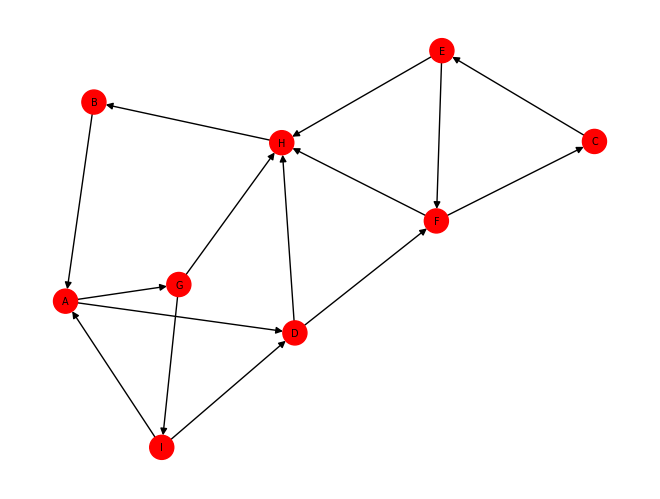

In [11]:

G = gerador()
desenha(G)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(G) else 'O grafo não é ligado.'
print(ligado)

O grafo é ligado!
Foram removidas 6 arestas.


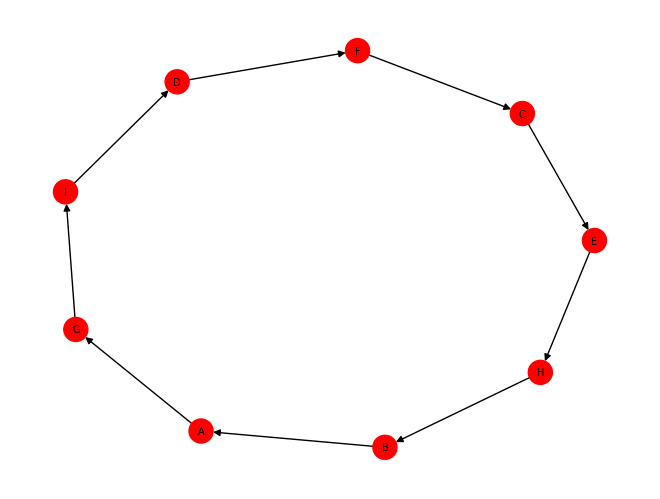

In [12]:
S = gerador_subgrafo(G)
desenha(S)
ligado = 'O grafo é ligado!' if nx.is_strongly_connected(S) else 'O grafo não é ligado.'
print(ligado)
print(f'Foram removidas {len(G.edges()) - len(S.edges())} arestas.')